In [1]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "images"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")


PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [3]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "densenet201":
        model_ft = models.densenet201(pretrained=use_pretrained)
        input_size=224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

In [6]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [7]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "densenet201"

# Number of classes in the dataset
# Abnormal,Benign,Normal
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True


# data dir
data_dir = "images"

In [8]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [9]:
# Only run this module and the next if the code is being run for the first time, else only run till the previous module
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [10]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

Epoch 0/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.6658 Acc: 0.7968


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2237 Acc: 0.9170

Epoch 1/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4400 Acc: 0.8485


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.96s/it]


val Loss: 0.2330 Acc: 0.9345


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 2/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4153 Acc: 0.8463


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4422 Acc: 0.8210

Epoch 3/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3744 Acc: 0.8685


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1793 Acc: 0.9258

Epoch 4/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3533 Acc: 0.8762


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2463 Acc: 0.9258

Epoch 5/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3722 Acc: 0.8685


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1878 Acc: 0.9345

Epoch 6/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3561 Acc: 0.8762


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2730 Acc: 0.9039

Epoch 7/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3435 Acc: 0.8832


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2142 Acc: 0.9258

Epoch 8/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3299 Acc: 0.8854


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2438 Acc: 0.9083

Epoch 9/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2753 Acc: 0.8990


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1638 Acc: 0.9389

Epoch 10/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3049 Acc: 0.8946


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1675 Acc: 0.9432

Epoch 11/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3187 Acc: 0.8838


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1776 Acc: 0.9345

Epoch 12/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2837 Acc: 0.8963


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1635 Acc: 0.9432

Epoch 13/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3005 Acc: 0.8903


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2010 Acc: 0.9170

Epoch 14/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3115 Acc: 0.8957


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1588 Acc: 0.9345

Epoch 15/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2670 Acc: 0.9001


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1552 Acc: 0.9476

Epoch 16/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2566 Acc: 0.9098


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1790 Acc: 0.9345

Epoch 17/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2616 Acc: 0.9109


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1861 Acc: 0.9389

Epoch 18/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2427 Acc: 0.9060


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1340 Acc: 0.9476

Epoch 19/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2772 Acc: 0.9044


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1627 Acc: 0.9389

Epoch 20/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2922 Acc: 0.9001


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1739 Acc: 0.9301

Epoch 21/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2439 Acc: 0.9082


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1365 Acc: 0.9520

Epoch 22/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2504 Acc: 0.9256


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1323 Acc: 0.9476

Epoch 23/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2522 Acc: 0.9104


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1570 Acc: 0.9432

Epoch 24/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2261 Acc: 0.9180


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5166 Acc: 0.8603

Epoch 25/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2550 Acc: 0.9153


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1607 Acc: 0.9345

Epoch 26/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2100 Acc: 0.9240


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1811 Acc: 0.9476

Epoch 27/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2217 Acc: 0.9180


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2565 Acc: 0.9301

Epoch 28/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2115 Acc: 0.9212


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1433 Acc: 0.9563

Epoch 29/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2056 Acc: 0.9229


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1822 Acc: 0.9389

Epoch 30/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2213 Acc: 0.9267


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1579 Acc: 0.9389

Epoch 31/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1793 Acc: 0.9354


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1336 Acc: 0.9651

Epoch 32/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2156 Acc: 0.9185


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1382 Acc: 0.9520

Epoch 33/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2016 Acc: 0.9299


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1296 Acc: 0.9476

Epoch 34/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1836 Acc: 0.9343


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1693 Acc: 0.9389

Epoch 35/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2024 Acc: 0.9288


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1017 Acc: 0.9563

Epoch 36/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1604 Acc: 0.9419


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1163 Acc: 0.9520

Epoch 37/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1552 Acc: 0.9446


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.0879 Acc: 0.9651

Epoch 38/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1760 Acc: 0.9446


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1351 Acc: 0.9651

Epoch 39/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1828 Acc: 0.9348


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1220 Acc: 0.9563

Epoch 40/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1757 Acc: 0.9348


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1918 Acc: 0.9170

Epoch 41/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1674 Acc: 0.9381


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1717 Acc: 0.9345

Epoch 42/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1645 Acc: 0.9408


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1009 Acc: 0.9651

Epoch 43/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1640 Acc: 0.9446


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1482 Acc: 0.9520

Epoch 44/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1290 Acc: 0.9484


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1079 Acc: 0.9563

Epoch 45/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1683 Acc: 0.9462


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.0855 Acc: 0.9607

Epoch 46/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1469 Acc: 0.9517


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1240 Acc: 0.9738

Epoch 47/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1613 Acc: 0.9457


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1223 Acc: 0.9476

Epoch 48/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1783 Acc: 0.9479


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1648 Acc: 0.9563

Epoch 49/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.1235 Acc: 0.9582


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.83s/it]


val Loss: 0.1586 Acc: 0.9476

Training complete in 957m 35s
Best val Acc: 0.973799


In [11]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/densenet201")

In [12]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

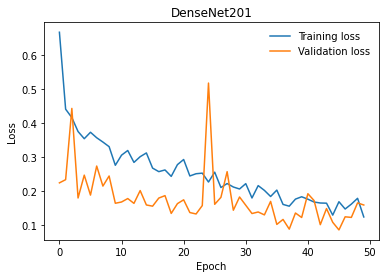

In [13]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("DenseNet201")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

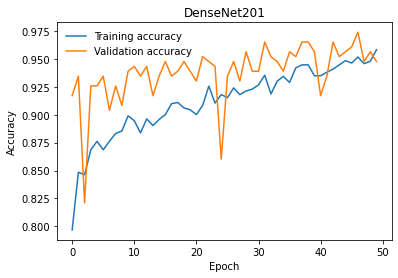

In [14]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("DenseNet201")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [15]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels

In [16]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "images"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)

In [17]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:27<00:00,  5.82s/it]


In [18]:
top1_acc

0.9527896995708155

In [19]:
# data directory of cropped images
data_dir = "images"
class_names = ['normal',
            'abnormal',
            'tumor']

In [20]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0] for x in class_name}

In [21]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [23]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)
epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:25<00:00,  5.70s/it]


In [24]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'abnormal': [2, 72, 2], 'normal': [94, 1, 2], 'tumor': [2, 1, 57]}
0.9570815450643777


In [25]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'abnormal': [0.02631578947368421, 0.9473684210526315, 0.02631578947368421],
 'normal': [0.9690721649484536, 0.010309278350515464, 0.020618556701030927],
 'tumor': [0.03333333333333333, 0.016666666666666666, 0.95]}

In [26]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

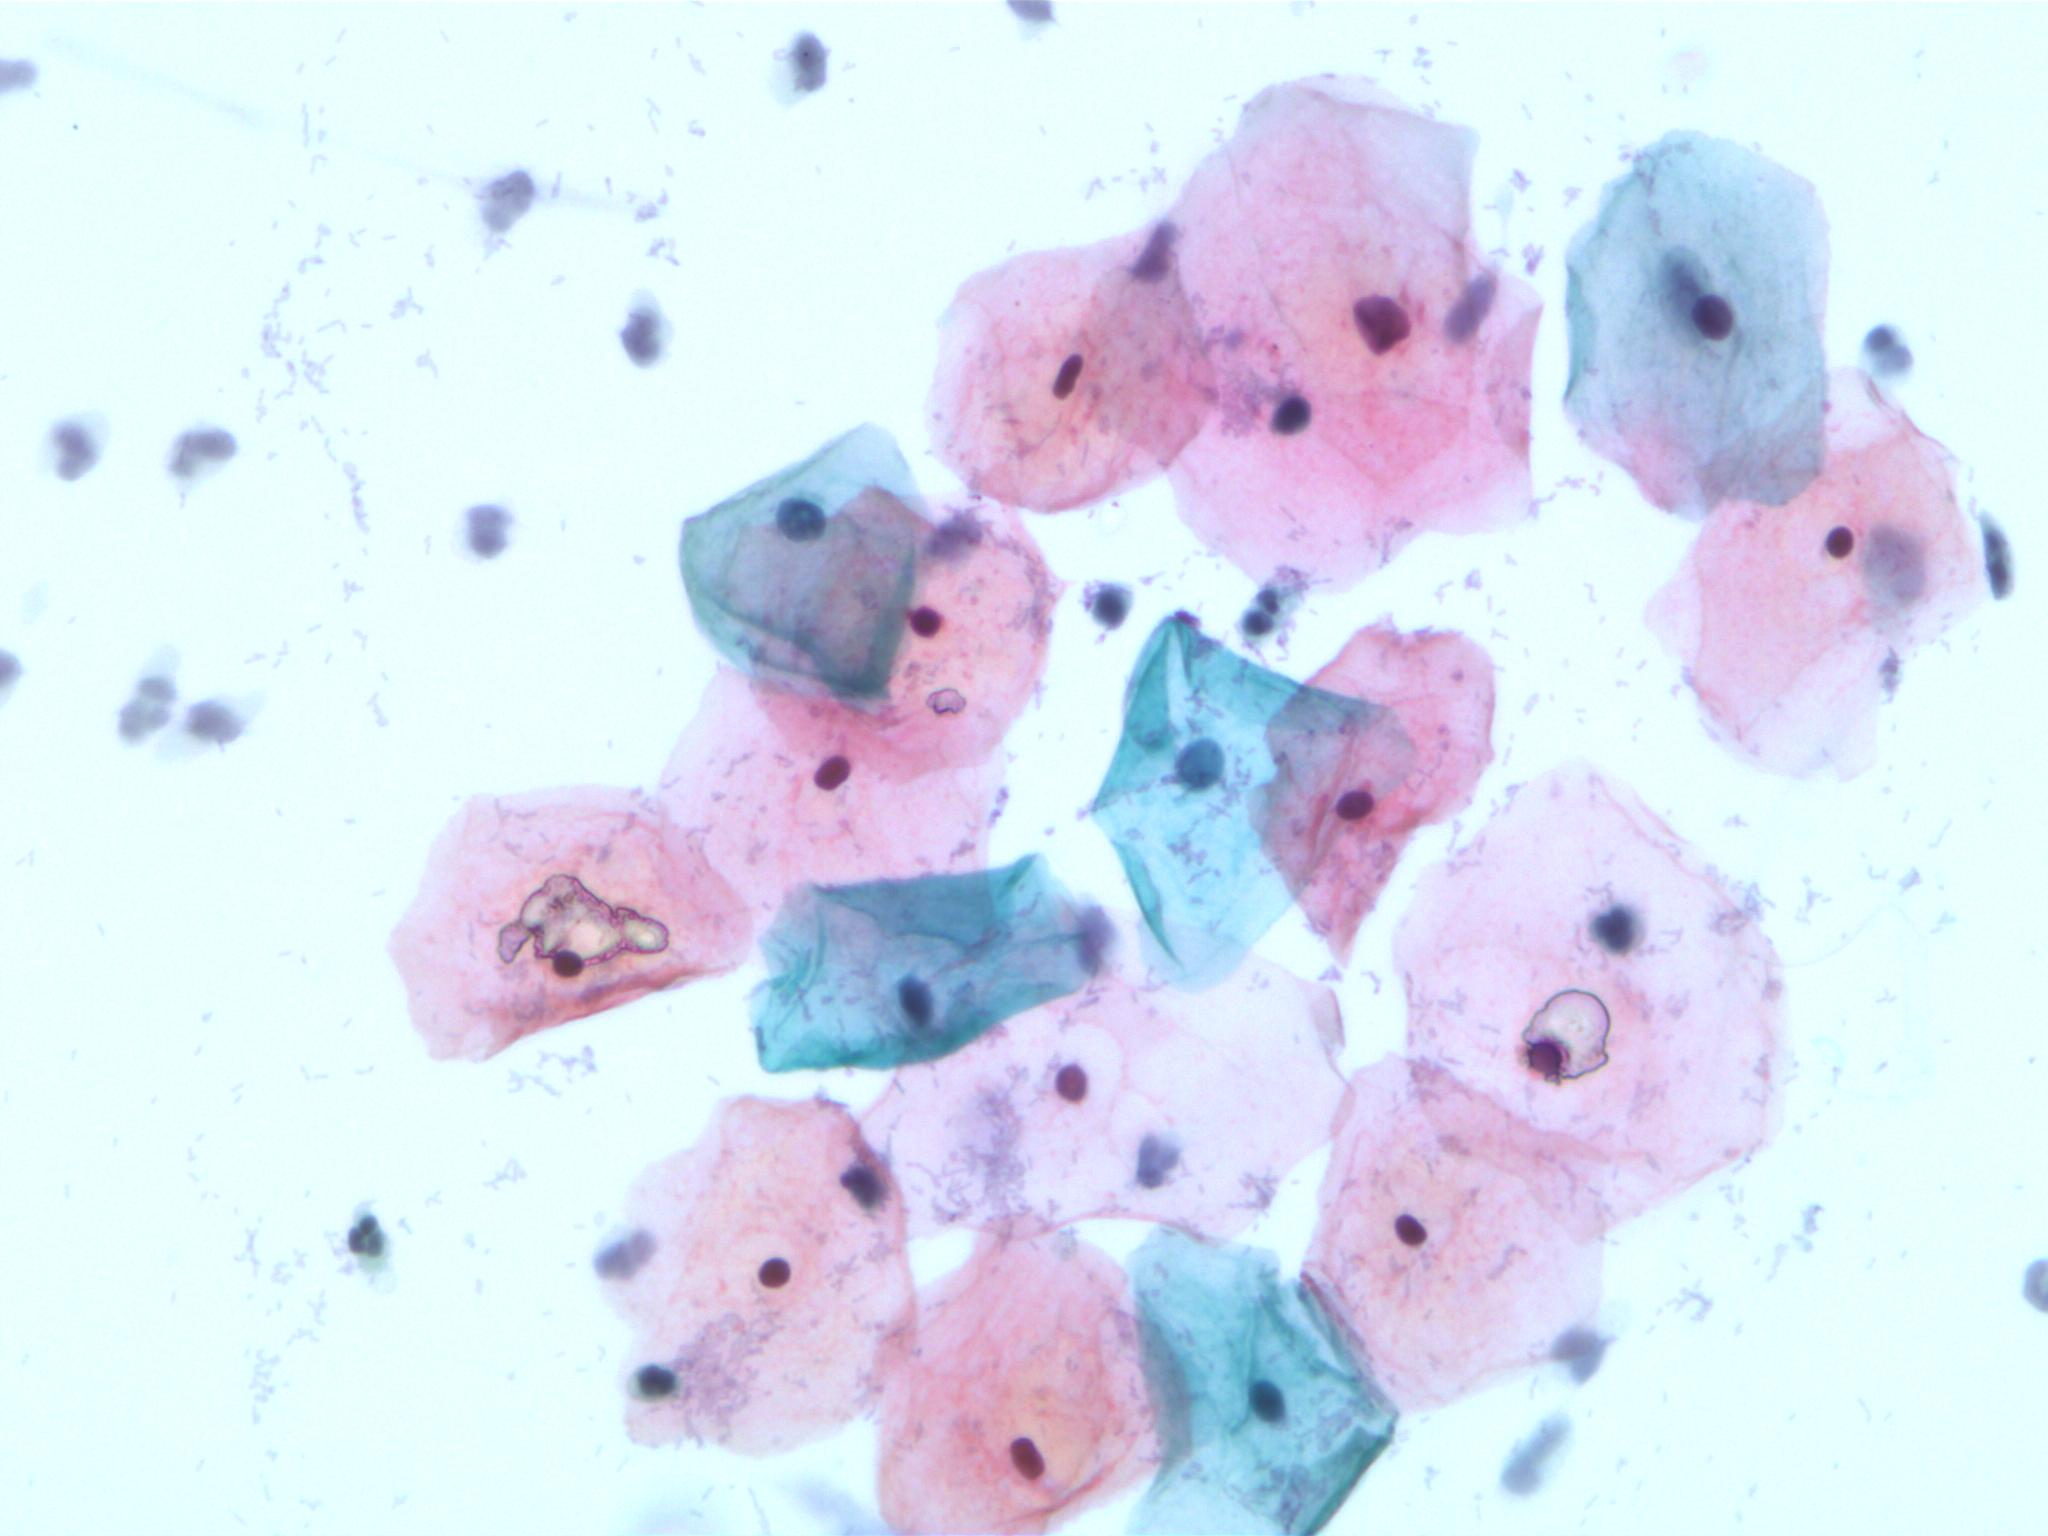

In [28]:
# view full image
img0 = PIL.Image.open('original_images/normal/75.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [29]:
# shape of full image
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 256, 256])


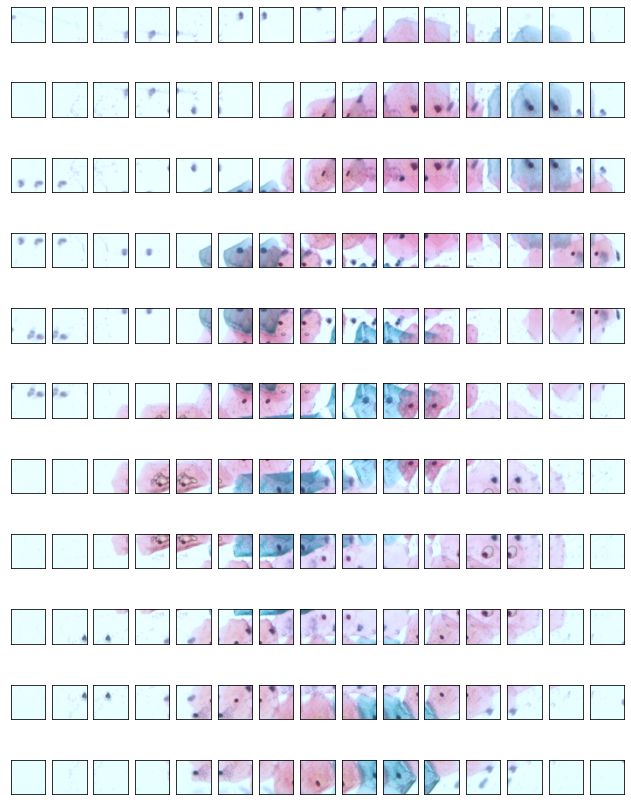

In [30]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('original_images/normal/75.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 256
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)

In [31]:
patches.shape

torch.Size([1, 11, 15, 3, 256, 256])

normal: 0.999902606010437


<ipython-input-32-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


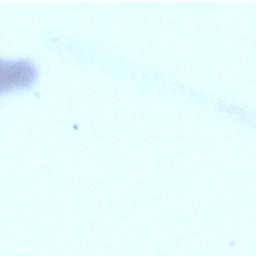

normal: 0.9999217987060547


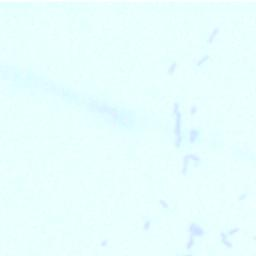

normal: 0.9998973608016968


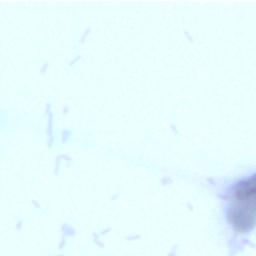

normal: 0.9998471736907959


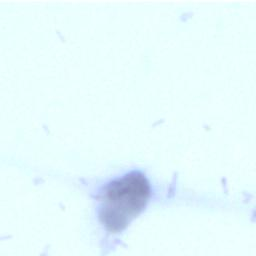

normal: 0.999896764755249


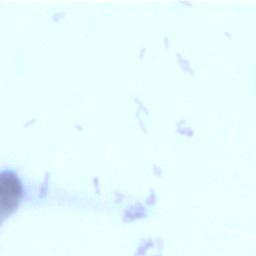

normal: 0.9998711347579956


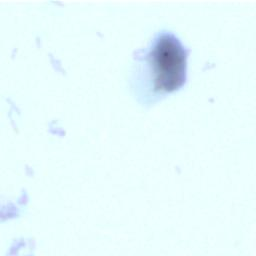

normal: 0.9998905658721924


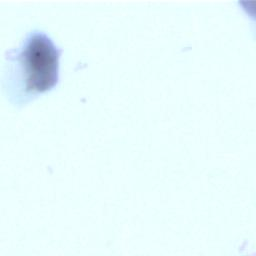

normal: 0.9999072551727295


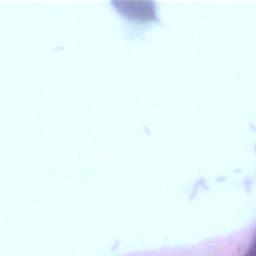

normal: 0.9992814660072327


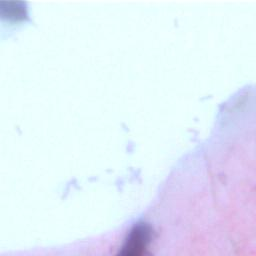

normal: 0.9977879524230957


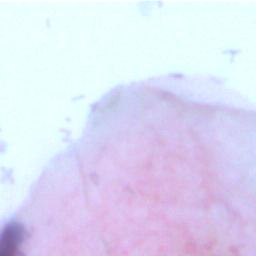

normal: 0.9966977834701538


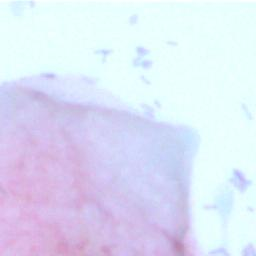

normal: 0.9994532465934753


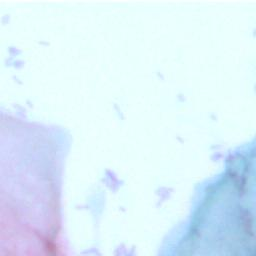

normal: 0.999842643737793


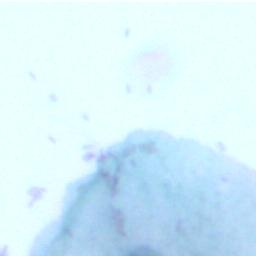

normal: 0.9996292591094971


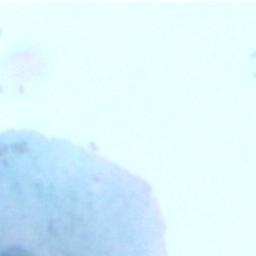

normal: 0.9998968839645386


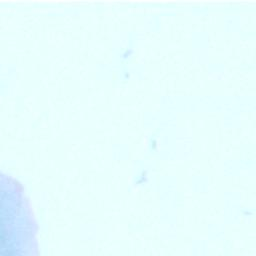

normal: 0.9999326467514038


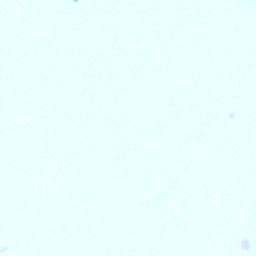

normal: 0.9999154806137085


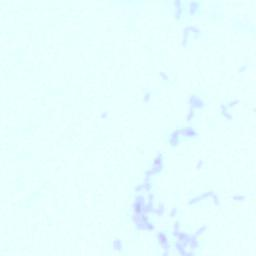

normal: 0.9998723268508911


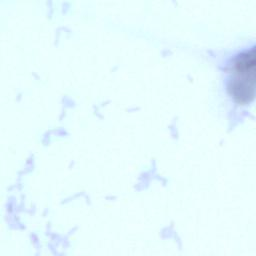

normal: 0.9998117089271545


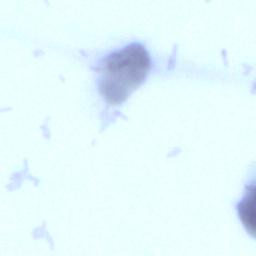

normal: 0.9998132586479187


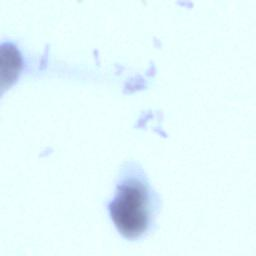

normal: 0.9999130964279175


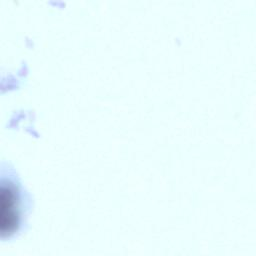

normal: 0.9998264908790588


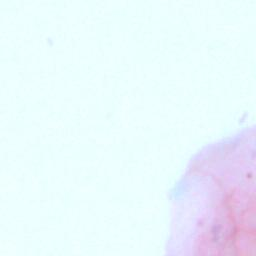

normal: 0.9996522665023804


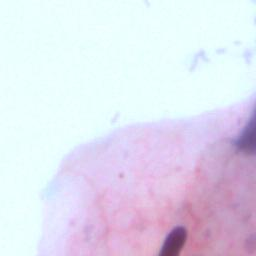

normal: 0.9986577033996582


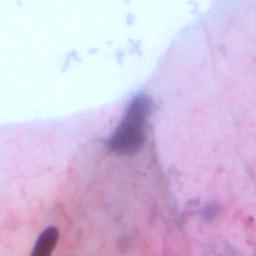

normal: 0.9968668818473816


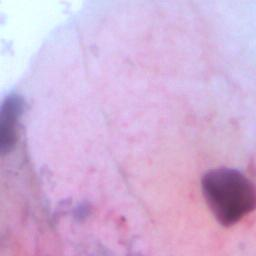

normal: 0.948814332485199


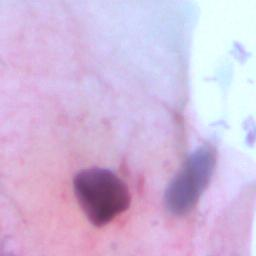

normal: 0.9913133978843689


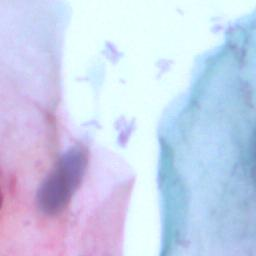

normal: 0.9998509883880615


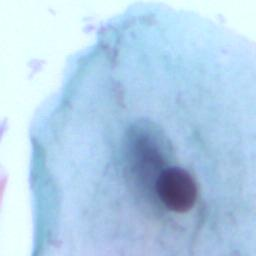

normal: 0.9991909861564636


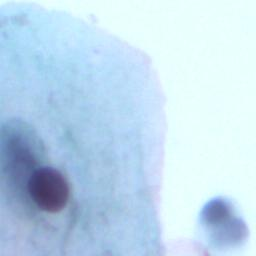

normal: 0.9996473789215088


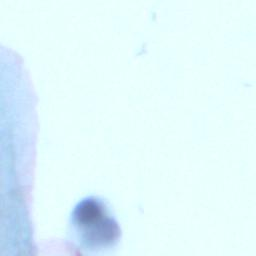

normal: 0.9997720122337341


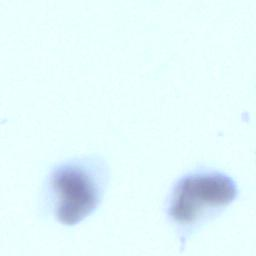

normal: 0.9998443126678467


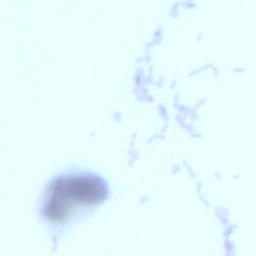

normal: 0.9999125003814697


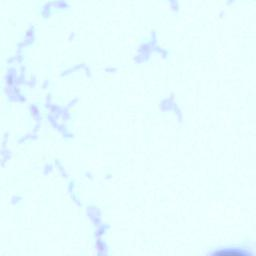

normal: 0.9999289512634277


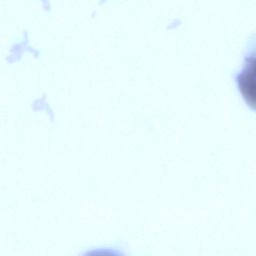

normal: 0.9998781681060791


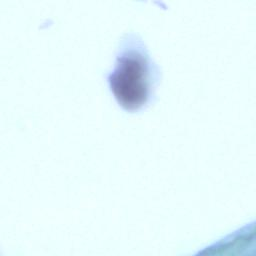

normal: 0.999893307685852


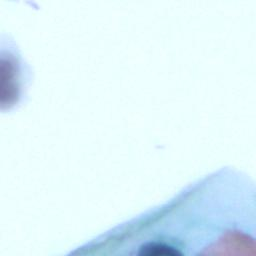

normal: 0.9987442493438721


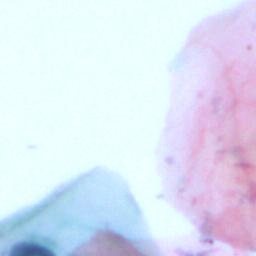

normal: 0.9974241256713867


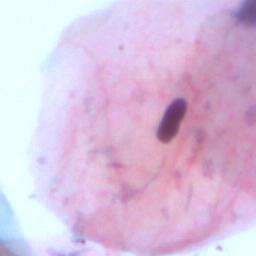

normal: 0.9986977577209473


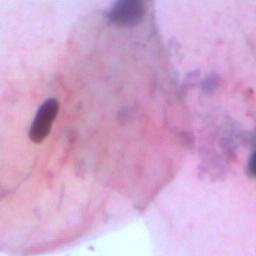

normal: 0.9984884262084961


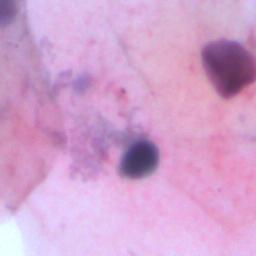

normal: 0.9753095507621765


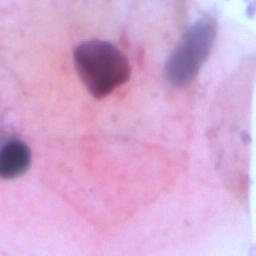

normal: 0.9560973644256592


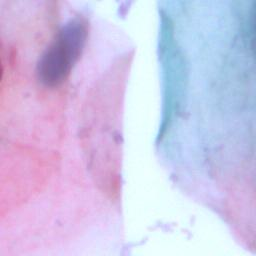

normal: 0.9989331364631653


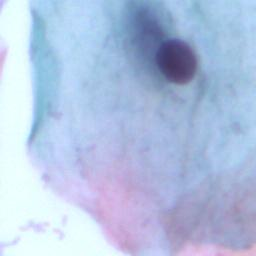

normal: 0.9945818781852722


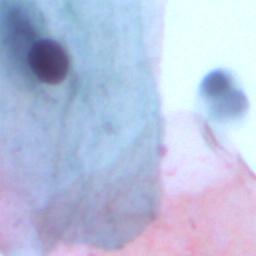

normal: 0.997438907623291


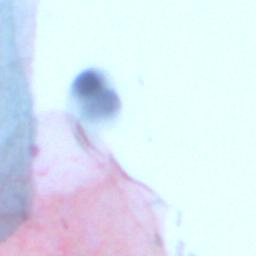

normal: 0.999761164188385


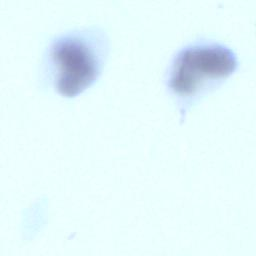

normal: 0.9998651742935181


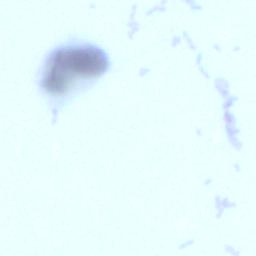

normal: 0.9998900890350342


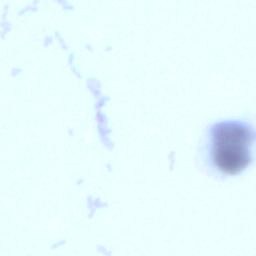

normal: 0.9998924732208252


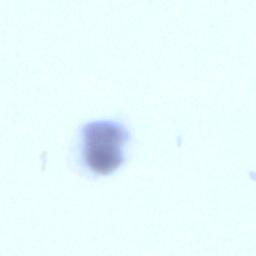

normal: 0.9998107552528381


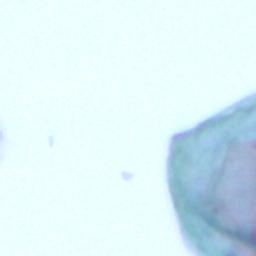

normal: 0.9999481439590454


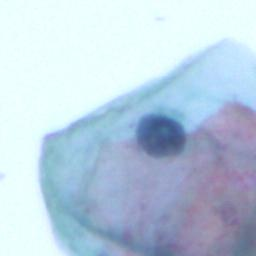

normal: 0.982989490032196


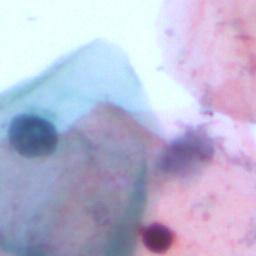

normal: 0.987360417842865


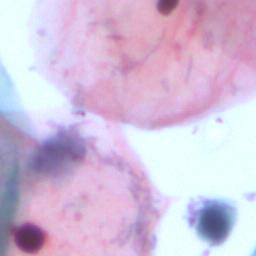

normal: 0.9981637597084045


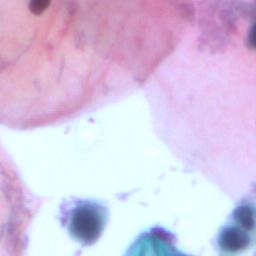

normal: 0.9972319006919861


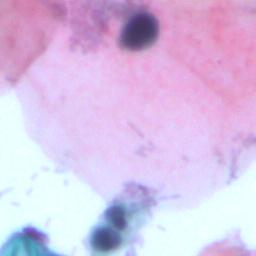

normal: 0.9955993890762329


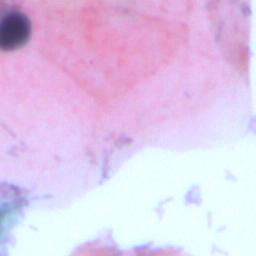

normal: 0.9981250166893005


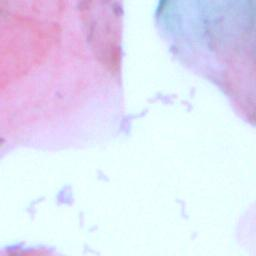

normal: 0.9907411336898804


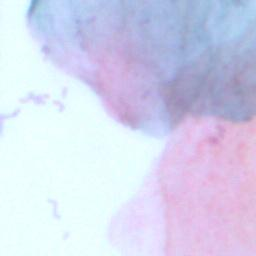

normal: 0.901624321937561


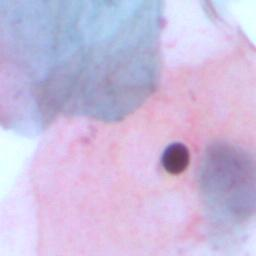

normal: 0.9637816548347473


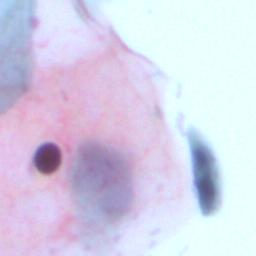

normal: 0.999757707118988


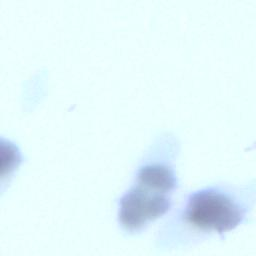

normal: 0.9997816681861877


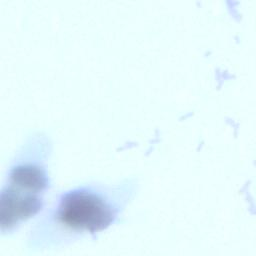

normal: 0.9999042749404907


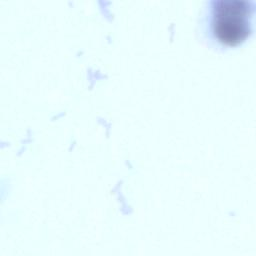

normal: 0.9999090433120728


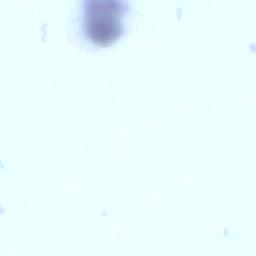

normal: 0.999302864074707


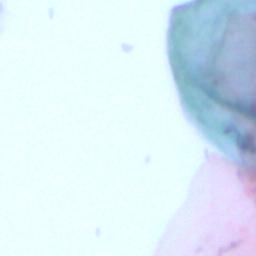

normal: 0.9992953538894653


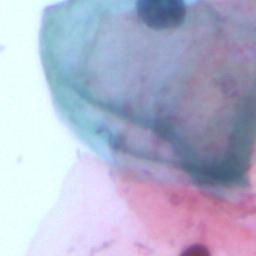

normal: 0.9275450706481934


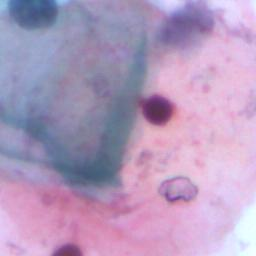

normal: 0.999988317489624


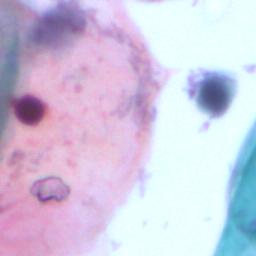

normal: 1.0


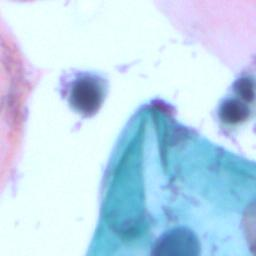

normal: 0.9999997615814209


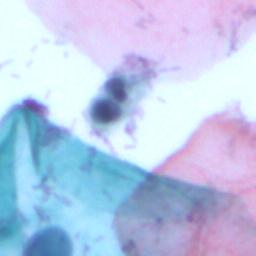

normal: 0.9981513619422913


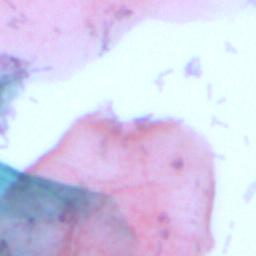

normal: 0.9997784495353699


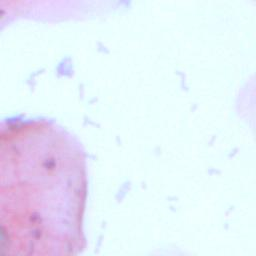

normal: 0.9973127245903015


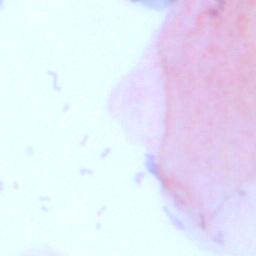

normal: 0.9283764362335205


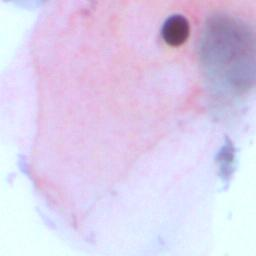

normal: 0.9847701787948608


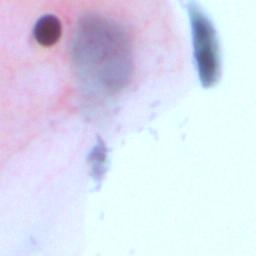

normal: 0.9997348189353943


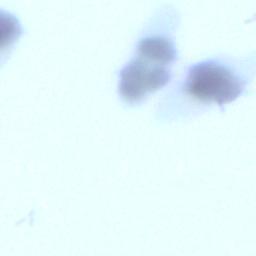

normal: 0.9997814297676086


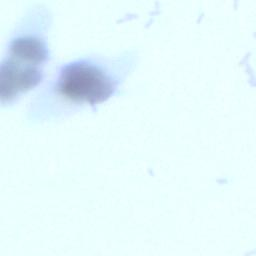

normal: 0.9998513460159302


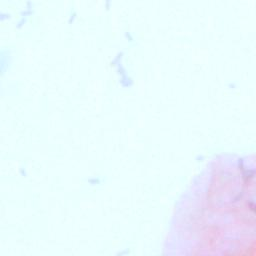

normal: 0.9991477727890015


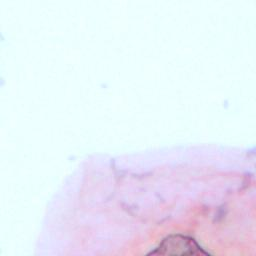

normal: 0.9940910935401917


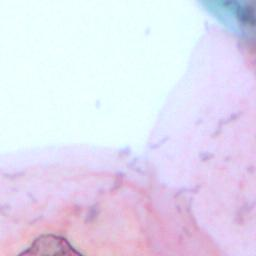

normal: 0.9913593530654907


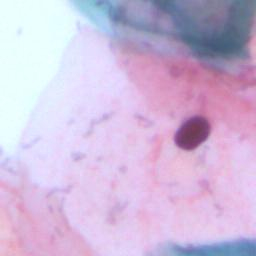

normal: 0.9981626868247986


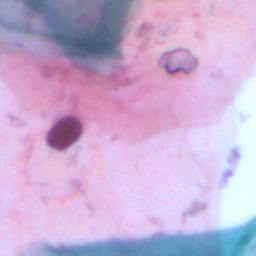

normal: 1.0


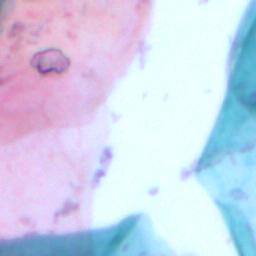

normal: 1.0


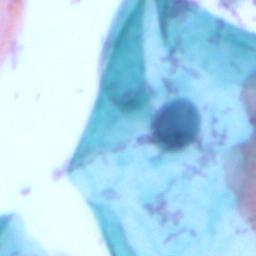

normal: 0.9999967813491821


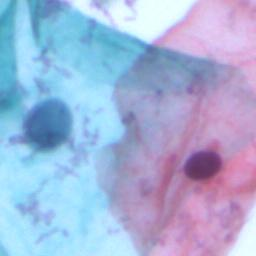

normal: 0.9973655343055725


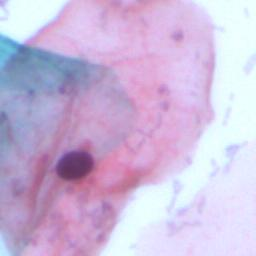

normal: 0.998200535774231


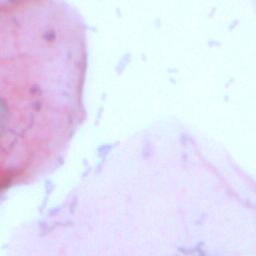

normal: 0.9975787997245789


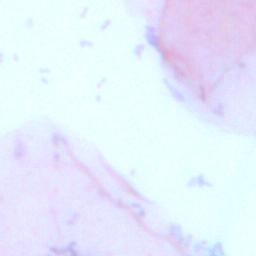

normal: 0.9962804913520813


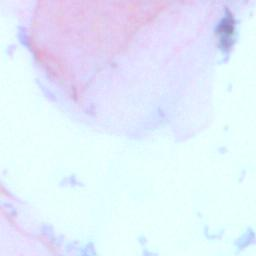

normal: 0.9996048808097839


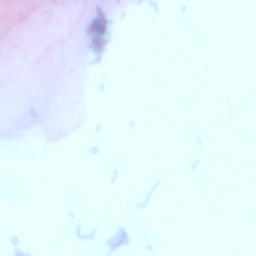

normal: 0.9999363422393799


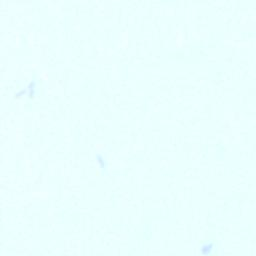

normal: 0.9999366998672485


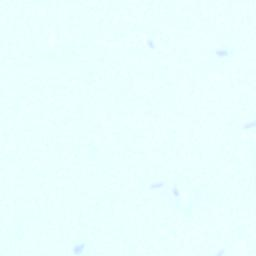

normal: 0.9987710118293762


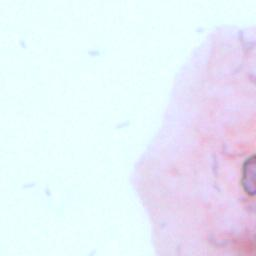

normal: 0.5612954497337341


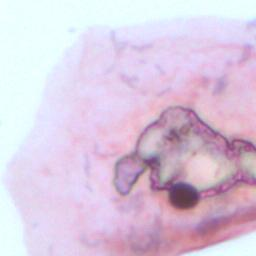

normal: 0.6763872504234314


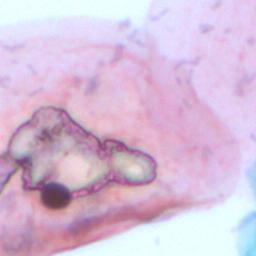

normal: 0.9961451292037964


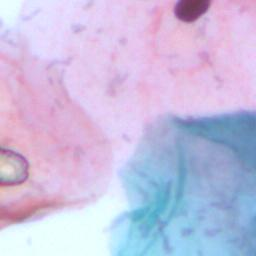

normal: 0.9999961853027344


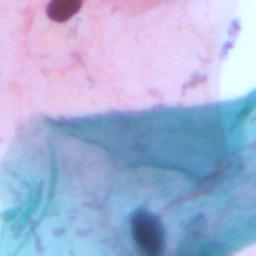

normal: 0.9999995231628418


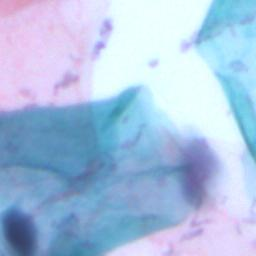

normal: 0.9999966621398926


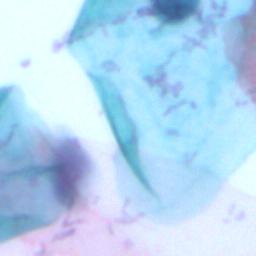

normal: 0.9999492168426514


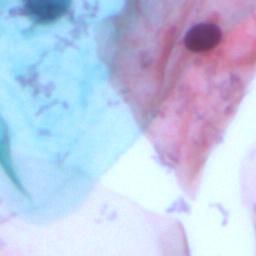

normal: 0.98021000623703


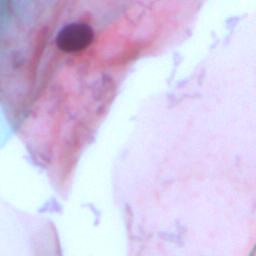

normal: 0.9674155116081238


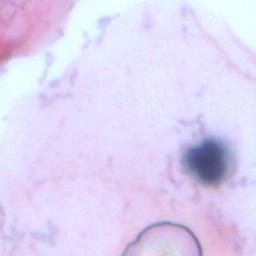

normal: 0.9877007007598877


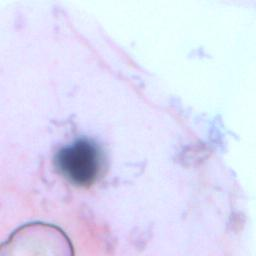

normal: 0.9993808269500732


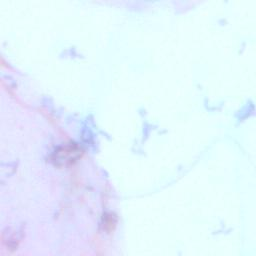

normal: 0.9999161958694458


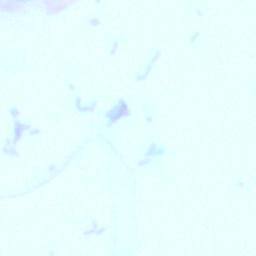

normal: 0.9999339580535889


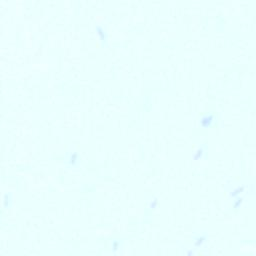

normal: 0.9999334812164307


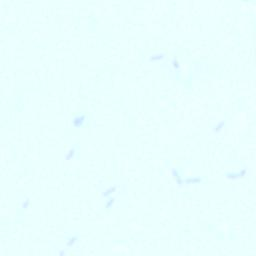

normal: 0.9990732669830322


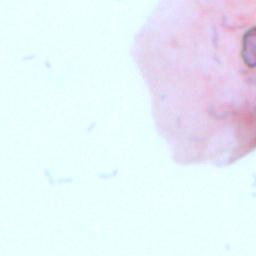

normal: 0.9715548753738403


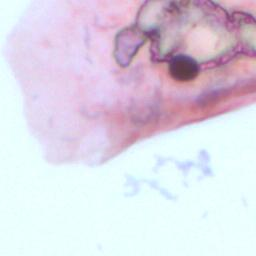

normal: 0.9904863238334656


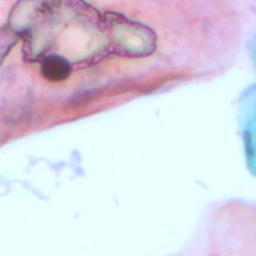

normal: 0.9999980926513672


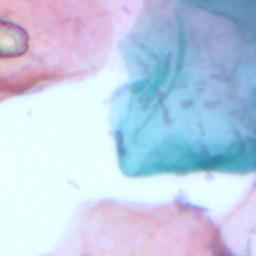

normal: 0.9999738931655884


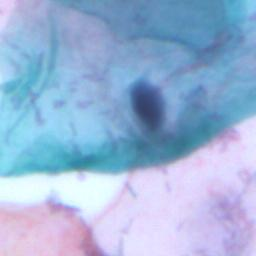

normal: 0.9994869232177734


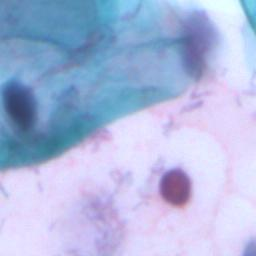

normal: 0.9986883997917175


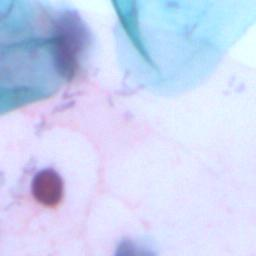

normal: 0.998106837272644


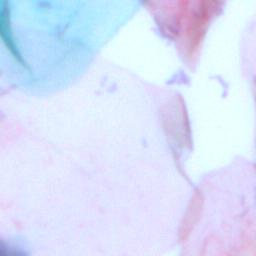

normal: 0.9621150493621826


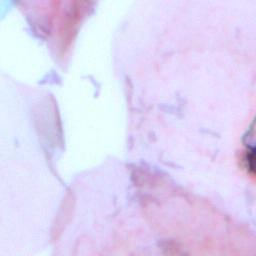

abnormal: 0.5299589037895203


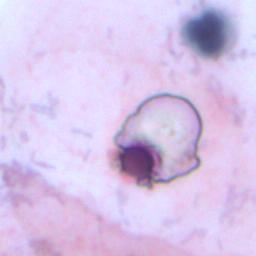

normal: 0.753803551197052


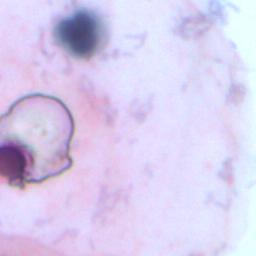

normal: 0.9973127245903015


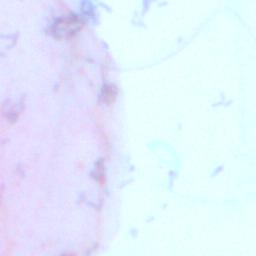

normal: 0.9999210834503174


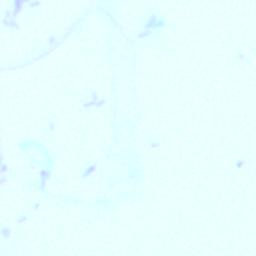

normal: 0.9999303817749023


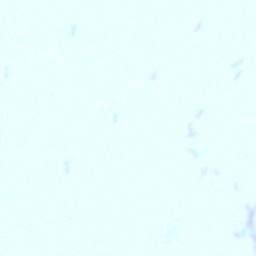

normal: 0.9998939037322998


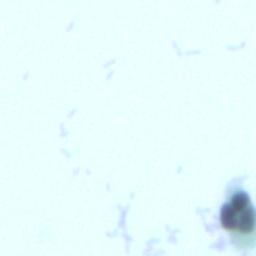

normal: 0.9997982382774353


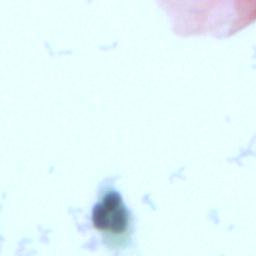

normal: 0.9997952580451965


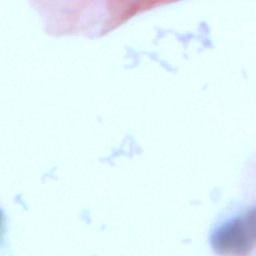

normal: 0.9982059001922607


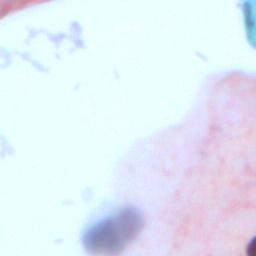

normal: 0.9999231100082397


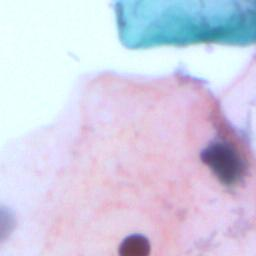

normal: 0.9996973276138306


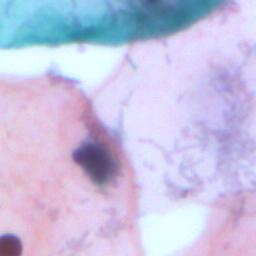

normal: 0.9734525680541992


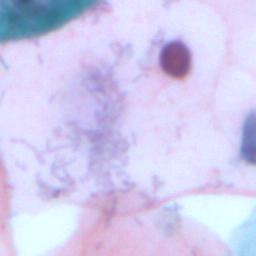

normal: 0.9698989987373352


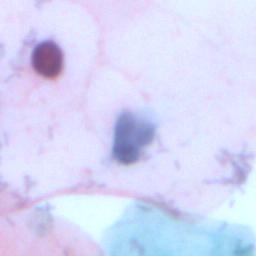

normal: 0.962129533290863


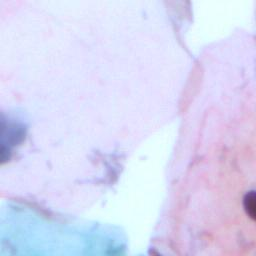

normal: 0.9425898194313049


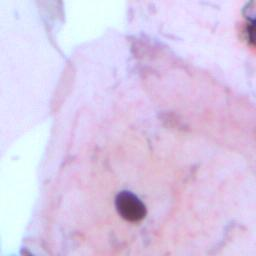

normal: 0.6898400783538818


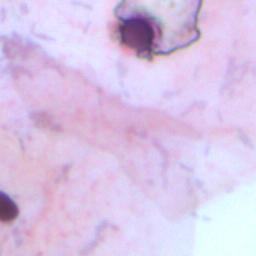

normal: 0.9426748752593994


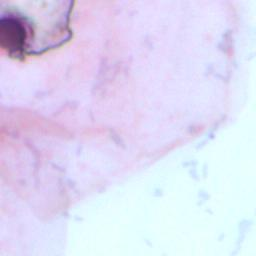

normal: 0.9991016387939453


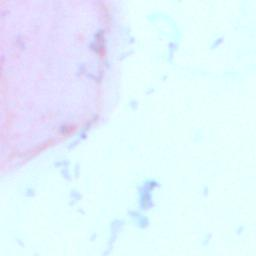

normal: 0.9999117851257324


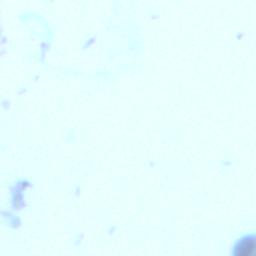

normal: 0.9999268054962158


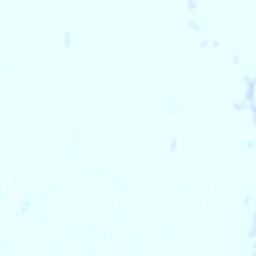

normal: 0.9998767375946045


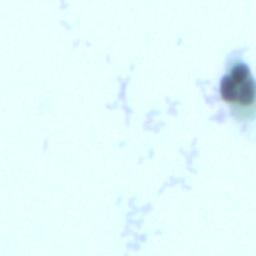

normal: 0.9998552799224854


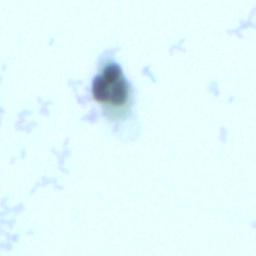

normal: 0.9998606443405151


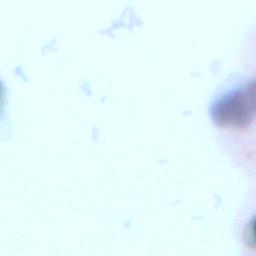

normal: 0.9802433848381042


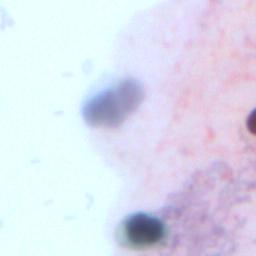

abnormal: 0.6747738122940063


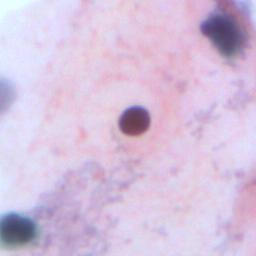

normal: 0.7838473320007324


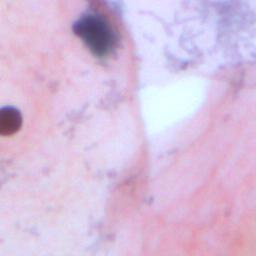

normal: 0.9924499988555908


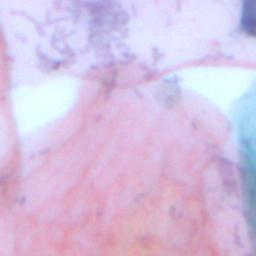

normal: 0.9999899864196777


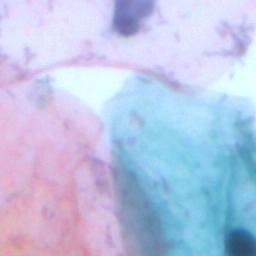

normal: 0.9999881982803345


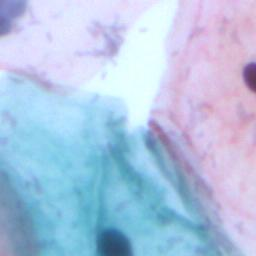

normal: 0.9954723119735718


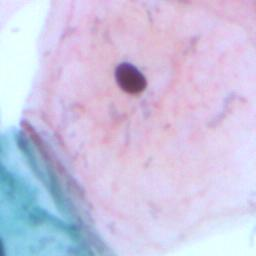

normal: 0.9032664895057678


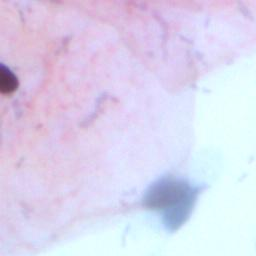

normal: 0.997298538684845


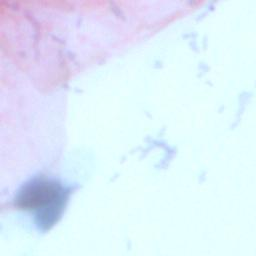

normal: 0.9998403787612915


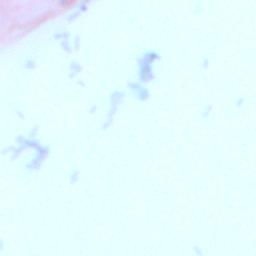

normal: 0.9999020099639893


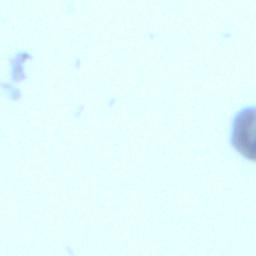

normal: 0.999920129776001


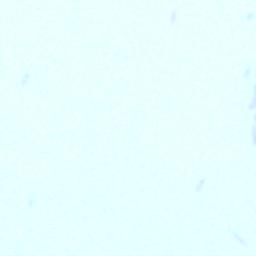

normal: 0.9999113082885742


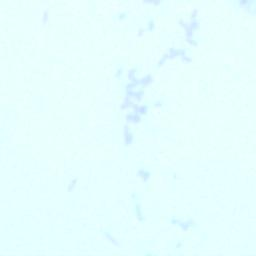

normal: 0.9999140501022339


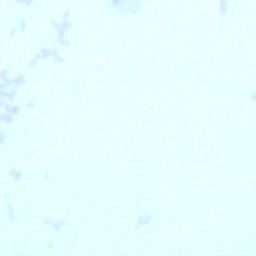

normal: 0.9998960494995117


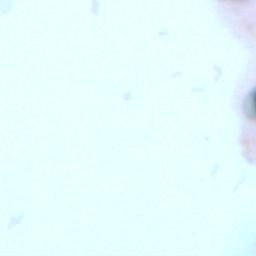

normal: 0.9963680505752563


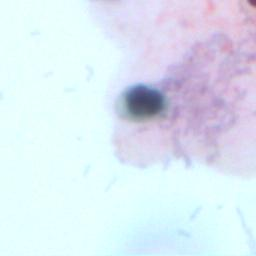

normal: 0.8825734257698059


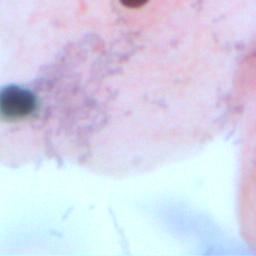

normal: 0.9468870759010315


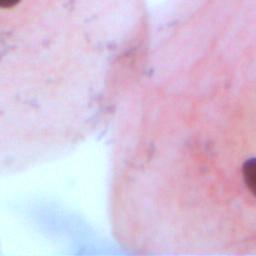

normal: 0.8680891990661621


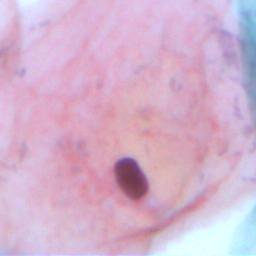

normal: 0.9999912977218628


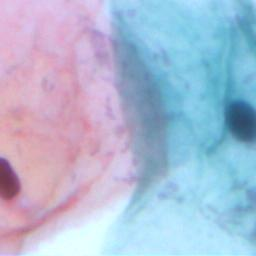

normal: 0.9999861717224121


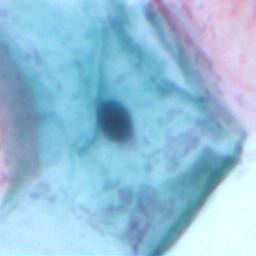

normal: 0.9999613761901855


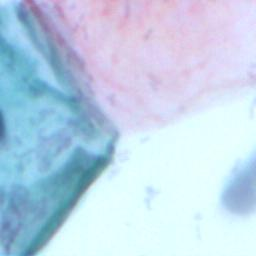

normal: 0.9948211908340454


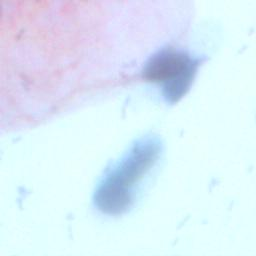

normal: 0.999600350856781


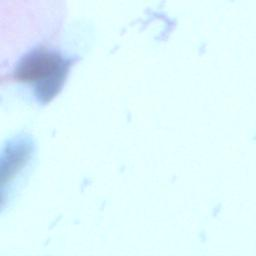

normal: 0.9999067783355713


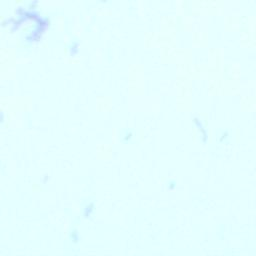

normal: 0.999907374382019


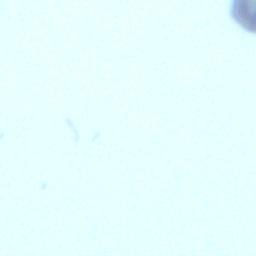

In [32]:
input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)